<a href="https://colab.research.google.com/github/debaonline4u/Machine-Learning-with-Python/blob/main/Encoder%20Decoder%20for%20Time%20series%20forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
url = f"https://raw.githubusercontent.com/Apress/hands-on-time-series-analylsis-python/master/Data/Metro_Interstate_Traffic_Volume.csv"

In [ ]:
data = pd.read_csv(url)

In [ ]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [ ]:
data.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [ ]:
validate = data['traffic_volume'].tail(10)
data = data.drop(data['traffic_volume'].tail(10).index)

In [ ]:
uni_data = data['traffic_volume']
uni_data.index = data['date_time']
uni_data.head()

date_time
2012-10-02 09:00:00    5545
2012-10-02 10:00:00    4516
2012-10-02 11:00:00    4767
2012-10-02 12:00:00    5026
2012-10-02 13:00:00    4918
Name: traffic_volume, dtype: int64

In [ ]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

In [ ]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
  X = []
  y = []

  start = start + window
  if end is None:
    end = len(dataset) - horizon

  for i in range(start, end):
    indicesx = range(i-window, i)
    X.append(np.reshape(dataset[indicesx], (window, 1)))
    indicesy = range(i,i+horizon)
    y.append(dataset[indicesy])
  return np.array(X), np.array(y)

In [ ]:
univar_hist_window = 48
horizon = 10
TRAIN_SPLIT = 30000
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target horizon')
print (y_train_uni[0])

Single window of past history
[[0.76167582]
 [0.62032967]
 [0.65480769]
 [0.69038462]
 [0.67554945]
 [0.71167582]
 [0.76703297]
 [0.82623626]
 [0.79546703]
 [0.65521978]
 [0.48612637]
 [0.38241758]
 [0.32431319]
 [0.21002747]
 [0.13228022]
 [0.06950549]
 [0.04409341]
 [0.0375    ]
 [0.05041209]
 [0.11181319]
 [0.37335165]
 [0.77925824]
 [0.89436813]
 [0.75151099]
 [0.70013736]
 [0.67129121]
 [0.7331044 ]
 [0.78186813]
 [0.84299451]
 [0.63502747]
 [0.49326923]
 [0.39807692]
 [0.36222527]
 [0.24409341]
 [0.13942308]
 [0.08214286]
 [0.05068681]
 [0.04285714]
 [0.05041209]
 [0.1146978 ]
 [0.37445055]
 [0.78145604]
 [0.96016484]
 [0.82211538]
 [0.72925824]
 [0.63228022]
 [0.67087912]
 [0.7010989 ]]

 Target horizon
[[0.71126374]
 [0.75563187]
 [0.78475275]
 [0.86428571]
 [0.83200549]
 [0.67403846]
 [0.48118132]
 [0.41717033]
 [0.38763736]
 [0.27362637]]


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 150
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_uni.shape[1]), 
    tf.keras.layers.LSTM(units=100,return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])
ED_lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
enco_deco.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 48, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 15)                3960      
                                                                 
 repeat_vector (RepeatVector  (None, 10, 15)           0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 10, 100)           46400     
                                                                 
 lstm_4 (LSTM)               (None, 10, 50)            30200     
                                                        

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = ED_lstm_model.fit(train_univariate, epochs=150,steps_per_epoch=100,validation_data=val_univariate, validation_steps=50,verbose =1)

Epoch 1/150
100/100 [==============================] - 55s 450ms/step - loss: 0.0958 - val_loss: 0.0709
Epoch 2/150
100/100 [==============================] - 43s 431ms/step - loss: 0.0605 - val_loss: 0.0573
Epoch 3/150
100/100 [==============================] - 43s 428ms/step - loss: 0.0537 - val_loss: 0.0753
Epoch 4/150
100/100 [==============================] - 43s 430ms/step - loss: 0.0491 - val_loss: 0.0461
Epoch 5/150
100/100 [==============================] - 43s 431ms/step - loss: 0.0499 - val_loss: 0.0424
Epoch 6/150
100/100 [==============================] - 43s 432ms/step - loss: 0.0455 - val_loss: 0.0418
Epoch 7/150
100/100 [==============================] - 43s 432ms/step - loss: 0.0441 - val_loss: 0.0359
Epoch 8/150
100/100 [==============================] - 43s 430ms/step - loss: 0.0436 - val_loss: 0.0357
Epoch 9/150
100/100 [==============================] - 43s 431ms/step - loss: 0.0418 - val_loss: 0.0461
Epoch 10/150
100/100 [==============================] - 43s 434m

In [ ]:
# create model
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import LSTM, TimeDistributed
enco_deco = Sequential()
# Encoder
enco_deco.add(LSTM(100, input_shape=x_train_uni.shape[-2:], return_sequences=True))
enco_deco.add(LSTM(units=50,return_sequences=True))
enco_deco.add(LSTM(units=15))
#feature vector
enco_deco.add(layers.RepeatVector(y_train_uni.shape[1]))
#decoder
enco_deco.add(LSTM(units=100,return_sequences=True))
enco_deco.add(LSTM(units=50,return_sequences=True))
enco_deco.add(TimeDistributed(tf.keras.layers.Dense(units=1)))

In [ ]:
enco_deco.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 48, 100)           40800     
                                                                 
 lstm_14 (LSTM)              (None, 48, 50)            30200     
                                                                 
 lstm_15 (LSTM)              (None, 15)                3960      
                                                                 
 repeat_vector_2 (RepeatVect  (None, 10, 15)           0         
 or)                                                             
                                                                 
 lstm_16 (LSTM)              (None, 10, 100)           46400     
                                                                 
 lstm_17 (LSTM)              (None, 10, 50)            30200     
                                                      

In [ ]:
uni = data['traffic_volume']
validatehori = uni.tail(48)

In [ ]:
validatehist = validatehori.values
scaler_val = preprocessing.MinMaxScaler()
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))

In [ ]:
val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))

In [ ]:
Predicted_results = ED_lstm_model.predict(val_rescaled)

In [ ]:
Predicted_results

array([[[0.6388559 ],
        [0.63769186],
        [0.63238335],
        [0.6240387 ],
        [0.60370827],
        [0.5555512 ],
        [0.4813918 ],
        [0.40486968],
        [0.33662346],
        [0.27134418]]], dtype=float32)

In [ ]:
Predicted_inver_res = scaler_x.inverse_transform(Predicted_results[0])

In [ ]:
Predicted_inver_res

array([[4074.2234],
       [4067.4104],
       [4036.3396],
       [3987.4985],
       [3868.5044],
       [3586.6409],
       [3152.5862],
       [2704.7021],
       [2305.257 ],
       [1923.1775]], dtype=float32)

In [ ]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(validate,Predicted_inver_res)}')
    print(f'MAE is : {metrics.mean_absolute_error(validate,Predicted_inver_res)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(validate,Predicted_inver_res))}')
    print(f'MAPE is : {mean_absolute_percentage_error(validate,Predicted_inver_res)}')
    print(f'R2 is : {metrics.r2_score(validate,Predicted_inver_res)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validate,Predicted_inver_res)

Evaluation metric results:-
MSE is : 255229.7545795381
MAE is : 408.9387451171875
RMSE is : 505.202686631354
MAPE is : 59.963241499333805
R2 is : 0.8343010016255124



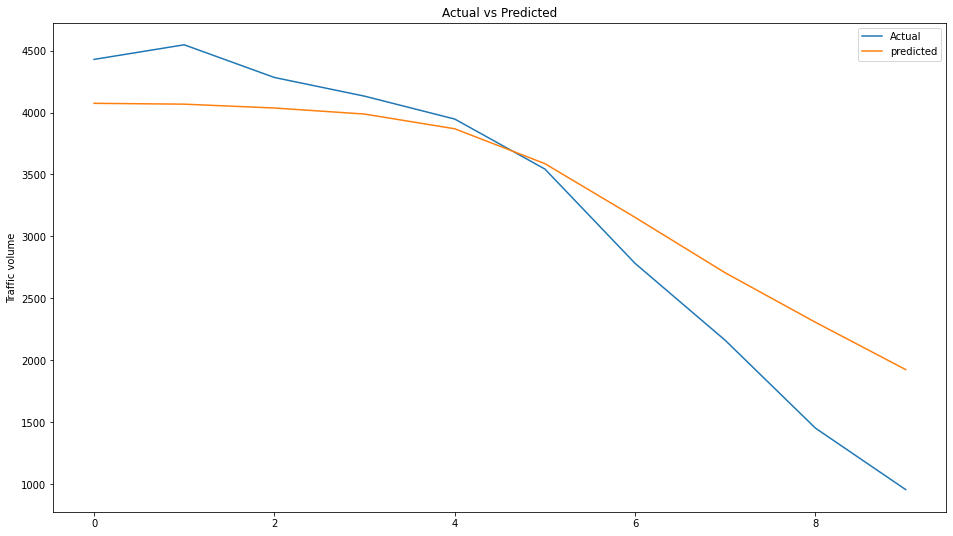

In [ ]:
plt.plot( list(validate))
plt.plot( list(Predicted_inver_res))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.rcParams["figure.figsize"] = [16,9]
plt.show()